In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sentence_transformers import SentenceTransformer, util

##### **Load NLI dataset into dataframe**

In [2]:
dataset = pd.read_csv('/home/ssever/contradiction-detection/data/csv_files/nli_data_set.csv')

dataset.head()

,id,premise,hypothesis,label_string,label
0,Mbf3G9tgFK,The Company has taken out a commercially appro...,The Company has measures in place to financial...,entailment,1
1,j0wiMc3zWN,The KION Group is also on a solid footing in t...,The financial performance of the KION Group in...,entailment,1
2,xMzxNivdex,It then raised this rating to BBB– with a stab...,It then raised this rating to BBB– with a stab...,entailment,1
3,mLC4faHDjU,Impairment losses decreased by €12.5 million t...,The new amount of impairment losses is €0.3 mi...,entailment,1
4,QqcccwK2Vk,Financial services support the sale of new tru...,Financial services hinder the sale of new truc...,factive_antonymity,2


In [3]:
label_names = [
    "antonymity",
    "entailment",
    "factive_antonymity",
    "factive_embedding_verb",
    "lexical",
    "negation",
    "neutral",
    "numeric",
    "structure",
    "temporal",
    "worldknowledge"
]

# Getting value counts
value_counts = dataset['label_string'].value_counts()

# Counting 'entailment' and 'neutral'
label_counts = {label: value_counts.get(label, 0) for label in label_names}
label_counts

{'antonymity': 167,
 'entailment': 1200,
 'factive_antonymity': 167,
 'factive_embedding_verb': 167,
 'lexical': 166,
 'negation': 167,
 'neutral': 749,
 'numeric': 167,
 'structure': 167,
 'temporal': 159,
 'worldknowledge': 166}

In [3]:
# evaluate the numeric contradictions

#filtered_df = dataset[dataset['label_string'] == 'numeric']
#styled_df = filtered_df.style.set_properties(**{'text-align': 'left'})
#styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

##### **Check for missing and duplicate values**

In [4]:
missing_values_count = dataset.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (missing_values_count)

Number of missing data points per column:

id              0
premise         0
hypothesis      0
label_string    0
label           0
dtype: int64


In [5]:
dataset["is_duplicate"] = dataset.duplicated()
dataset[dataset["is_duplicate"]==True].count()

id              0
premise         0
hypothesis      0
label_string    0
label           0
is_duplicate    0
dtype: int64

#### **Distribution of class labels**

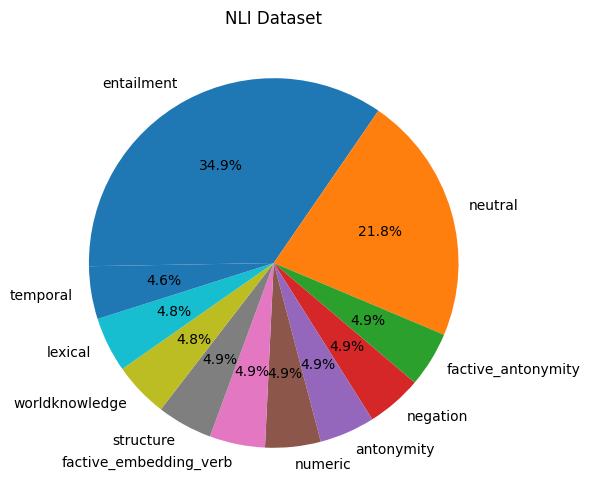

In [6]:
counts = dataset['label_string'].value_counts()

plt.figure(figsize = (6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=181, counterclock=False)
plt.title("NLI Dataset")
plt.show()

#### **Split the Dataset into Train and Test and oversample Train set**

In [12]:
X = dataset[['premise', 'hypothesis', 'label_string']]  # Features
y = dataset['label']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)
smote = SMOTE()

# Applying oversampling only to the training set
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check the change in size
print(f"Original train set size: {X.shape[0]}")
print(f"Resampled train set size: {X_train_resampled.shape[0]}")

Original train set size: 3442
Resampled train set size: 11880


In [14]:
train = pd.concat([X_train_resampled, y_train_resampled], axis=1)
test = pd.concat([X_test, y_test], axis = 1)

In [15]:
# check the number of rows and columns after split
print("Train data: {} \n".format(train.shape))
print("Test data: {} \n".format(test.shape))

Train data: (11880, 4) 

Test data: (345, 4) 



#### **Label distribution of train and test set**

In [ ]:
counts_train = train['label_string'].value_counts()
counts_test = test['label_string'].value_counts()

fig, axis = plt.subplots(1, 2, figsize=(14, 4))

# Train set plot
axis[0].pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=181, counterclock=False,)
axis[0].set_title("Train set")
axis[0].axis('equal')

# Test set plot
axis[1].pie(counts_test, labels=counts_test.index, autopct='%1.1f%%', startangle=181, counterclock=False,)
axis[1].set_title("Val set")
axis[1].axis('equal')

plt.show()

#### **Load tokenizer**

In [8]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
#tokenizer = AutoTokenizer.from_pretrained('roberta-large')
#tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
#tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

#### **Encode train and test set**

In [ ]:
# Join premise with hypothesis
#features_train = list(zip(train['premise'], train['hypothesis']))
#features_test = list(zip(test['premise'], test['hypothesis']))
features_train = train[['premise', 'hypothesis']].values.tolist()
features_test = test[['premise', 'hypothesis']].values.tolist()

In [19]:
# tokenize the text feature
tokenized_features_train = tokenizer.batch_encode_plus(features_train)
tokenized_features_test = tokenizer.batch_encode_plus(features_test)
len(tokenized_features_train)

2

In [ ]:
ros = RandomOverSampler(random_state=42)

train_resampled, test_resampled = ros.fit_resample(tokenized_features_train, tokenized_features_test)

In [21]:
tokenized_features_train.keys()

dict_keys(['input_ids', 'attention_mask'])

#### **Tokenized data exploration**

In [22]:
# Example of how XLM-RoBERTa tokenizes sentences
print({x : tokenizer.encode(x, add_special_tokens=False) for x in dataset.values[0][1].split()})
len(tokenizer.encode(dataset.values[0][1], add_special_tokens=False))

{'The': [133], 'Company': [21960], 'has': [7333], 'taken': [90, 12578], 'out': [995], 'a': [102], 'commercially': [175, 2089, 24354], 'appropriate': [23360], 'level': [4483], 'of': [1116], 'insurance': [1344, 12590], 'to': [560], 'limit': [42425], 'the': [627], 'risk': [10848], 'potential': [8024, 12986], 'losses.': [13242, 293, 4]}


19

In [23]:
# collect tokenized train features sentence length 
token_train_length = [len(x) for x in tokenized_features_train['input_ids']]
print('max: ', max(token_train_length))
print('min: ', min(token_train_length))

max:  126
min:  18


In [24]:
# collect tokenized test features sentence length 
token_test_length = [len(x) for x in tokenized_features_test['input_ids']]
print('max: ', max(token_test_length))
print('min: ', min(token_test_length))

max:  120
min:  20


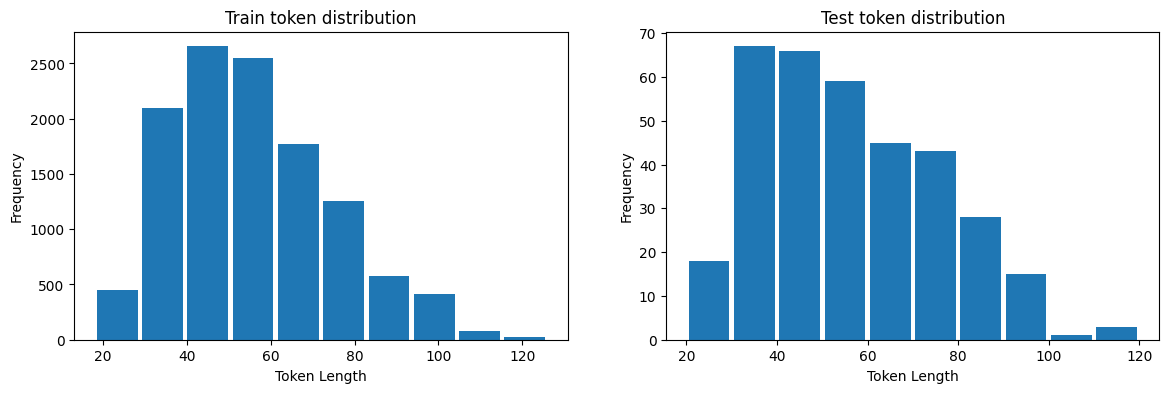

In [25]:
# plot token train and test distribution

fig, axis = plt.subplots(1, 2, figsize=(14, 4))

# Train token plot
axis[0].hist(token_train_length, rwidth = 0.9)
axis[0].set_title("Train token distribution", fontsize = 12)
axis[0].set_xlabel("Token Length")
axis[0].set_ylabel("Frequency") 

# Test token plot
axis[1].hist(token_test_length, rwidth = 0.9)
axis[1].set_title("Test token distribution", fontsize = 12)
axis[1].set_xlabel("Token Length")
axis[1].set_ylabel("Frequency") 

plt.show()

## **Box plot of embedding similarity scores**

In [20]:
# Load embedding model
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L12-v2')
#model = SentenceTransformer('all-mpnet-base-v2')

In [23]:
print(next(model.parameters()).device)

cuda:0


In [21]:
# Load and embed premises and hypotheses

data = pd.read_csv('/home/ssever/contradiction-detection/data/csv_files/nli_data_set.csv')
datalist = list(zip(data['premise'], data['hypothesis'], data['label_string']))

encoded_list = [(model.encode(premise), model.encode(hypothesis), label) for premise, hypothesis, label in datalist]

In [13]:
# Calculate similarity scores

scores_list = [(util.cos_sim(premise, hypothesis), label) for premise, hypothesis, label in encoded_list]
scores_list = [(round(float(tensor[0][0]), 5), label) for tensor, label in scores_list]

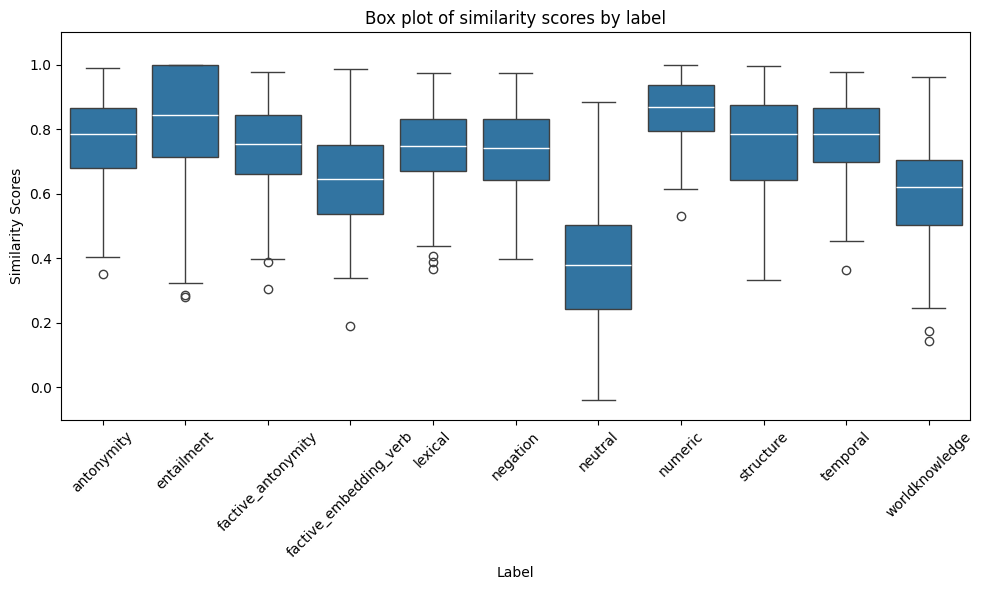

In [14]:
# List of target labels
target_names = [
    "antonymity",
    "entailment",
    "factive_antonymity",
    "factive_embedding_verb",
    "lexical",
    "negation",
    "neutral",
    "numeric",
    "structure",
    "temporal",
    "worldknowledge"
]

# Create DataFrame
df = pd.DataFrame(scores_list, columns=['Score', 'Label'])
df = df[df['Label'].isin(target_names)]

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Score', data=df, order=target_names, medianprops={'color': 'white'})

# Plot
plt.xticks(rotation=45)
plt.ylim(-0.1, 1.1)
plt.title('Box plot of similarity scores by label')
plt.xlabel('Label')
plt.ylabel('Similarity Scores')
plt.tight_layout()
plt.show()

In [15]:
# Checking outliers for entailment pairs

zipped = list(zip(data['premise'], data['hypothesis'], scores_list))
entailments = [element for element in zipped if element[2][1] == 'entailment' and element[2][0] <= 0.4]
len(entailments)

9

#### **Backup**

In [ ]:
#### **Backup**
# Calculate means and draw a line for each box at the mean position
for i, label in enumerate(target_names):
    label_scores = df[df['Label'] == label]['Score']
    mean_score = label_scores.mean()
    
    # Draws a horizontal line for the mean
    plt.hlines(mean_score, i - 0.4, i + 0.4, colors='white', linestyles='dashed')